<a href="https://colab.research.google.com/github/SFauth/finance_research/blob/main/portfolio_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portfolio 2022

The purpose of this notebook is to find a portfolio that minimizes risk, while providing a certain return. 

### Setting up the developing environment

In [ ]:
!pip install yfinance
!pip install fredapi

In [ ]:
import yfinance as yf
from fredapi import Fred
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt

### Question 1: Are the markets and certain single stocks overvalued? 

In order to answer this question from a macroeconomic perspective, let us first load some money supply (m1) data of the currencies that are of interest for investors. Our goal is to analyze the correlation between m1 and an asset. Given the volatile tendencies in current monetary economics, high correlation might be relevant for investment decisions.

#### Getting money supply data from FRED

In [ ]:
fred = Fred(api_key='25ed800f99a54753725b81afdef96acf')

In [ ]:
country_codes = {'m1_US':'M1SL',
                 'm1_EU':'MANMM101EZM189S',
                 'm1_China':'MANMM101CNM189S',
                 'm1_Korea': 'MANMM101KRM189S',
                 'm1_Indonesia':'MANMM101IDM189S',
                 'm1_Japan' : 'MANMM101JPM189S',
                 'm1_India' : 'MANMM101INM189S'
}

m1_ts = {country : fred.get_series(code) for country, code in country_codes.items()}
m1_ts_df = pd.DataFrame(dict([(country, pd.Series(country_codes)) for country, country_codes in m1_ts.items()]))

m1_ts_df.tail(5)

,m1_US,m1_EU,m1_China,m1_Korea,m1_Indonesia,m1_Japan,m1_India
2022-04-01,20615.3,1.149408e+13,NaN,1.370039e+15,NaN,1.013963e+15,5.211671e+13
2022-05-01,20620.8,1.155964e+13,NaN,1.387571e+15,NaN,1.013316e+15,5.244810e+13
2022-06-01,20545.0,1.161842e+13,NaN,1.380592e+15,NaN,1.019765e+15,5.193918e+13
2022-07-01,20516.0,1.168861e+13,NaN,NaN,NaN,1.023683e+15,NaN
2022-08-01,20452.9,NaN,NaN,NaN,NaN,NaN,NaN


We observe that certain time series contain missing values. Let us check, which contain the most:

In [ ]:
m1_ts_df.isna().sum()

m1_US            48
m1_EU           181
m1_China        572
m1_Korea         62
m1_Indonesia    464
m1_Japan         61
m1_India         62
dtype: int64

As expected the US series has the least. The missing values in the EU series are probably caused by the fact that the euro did not exist prior to 2002. Can we confirm this visually?

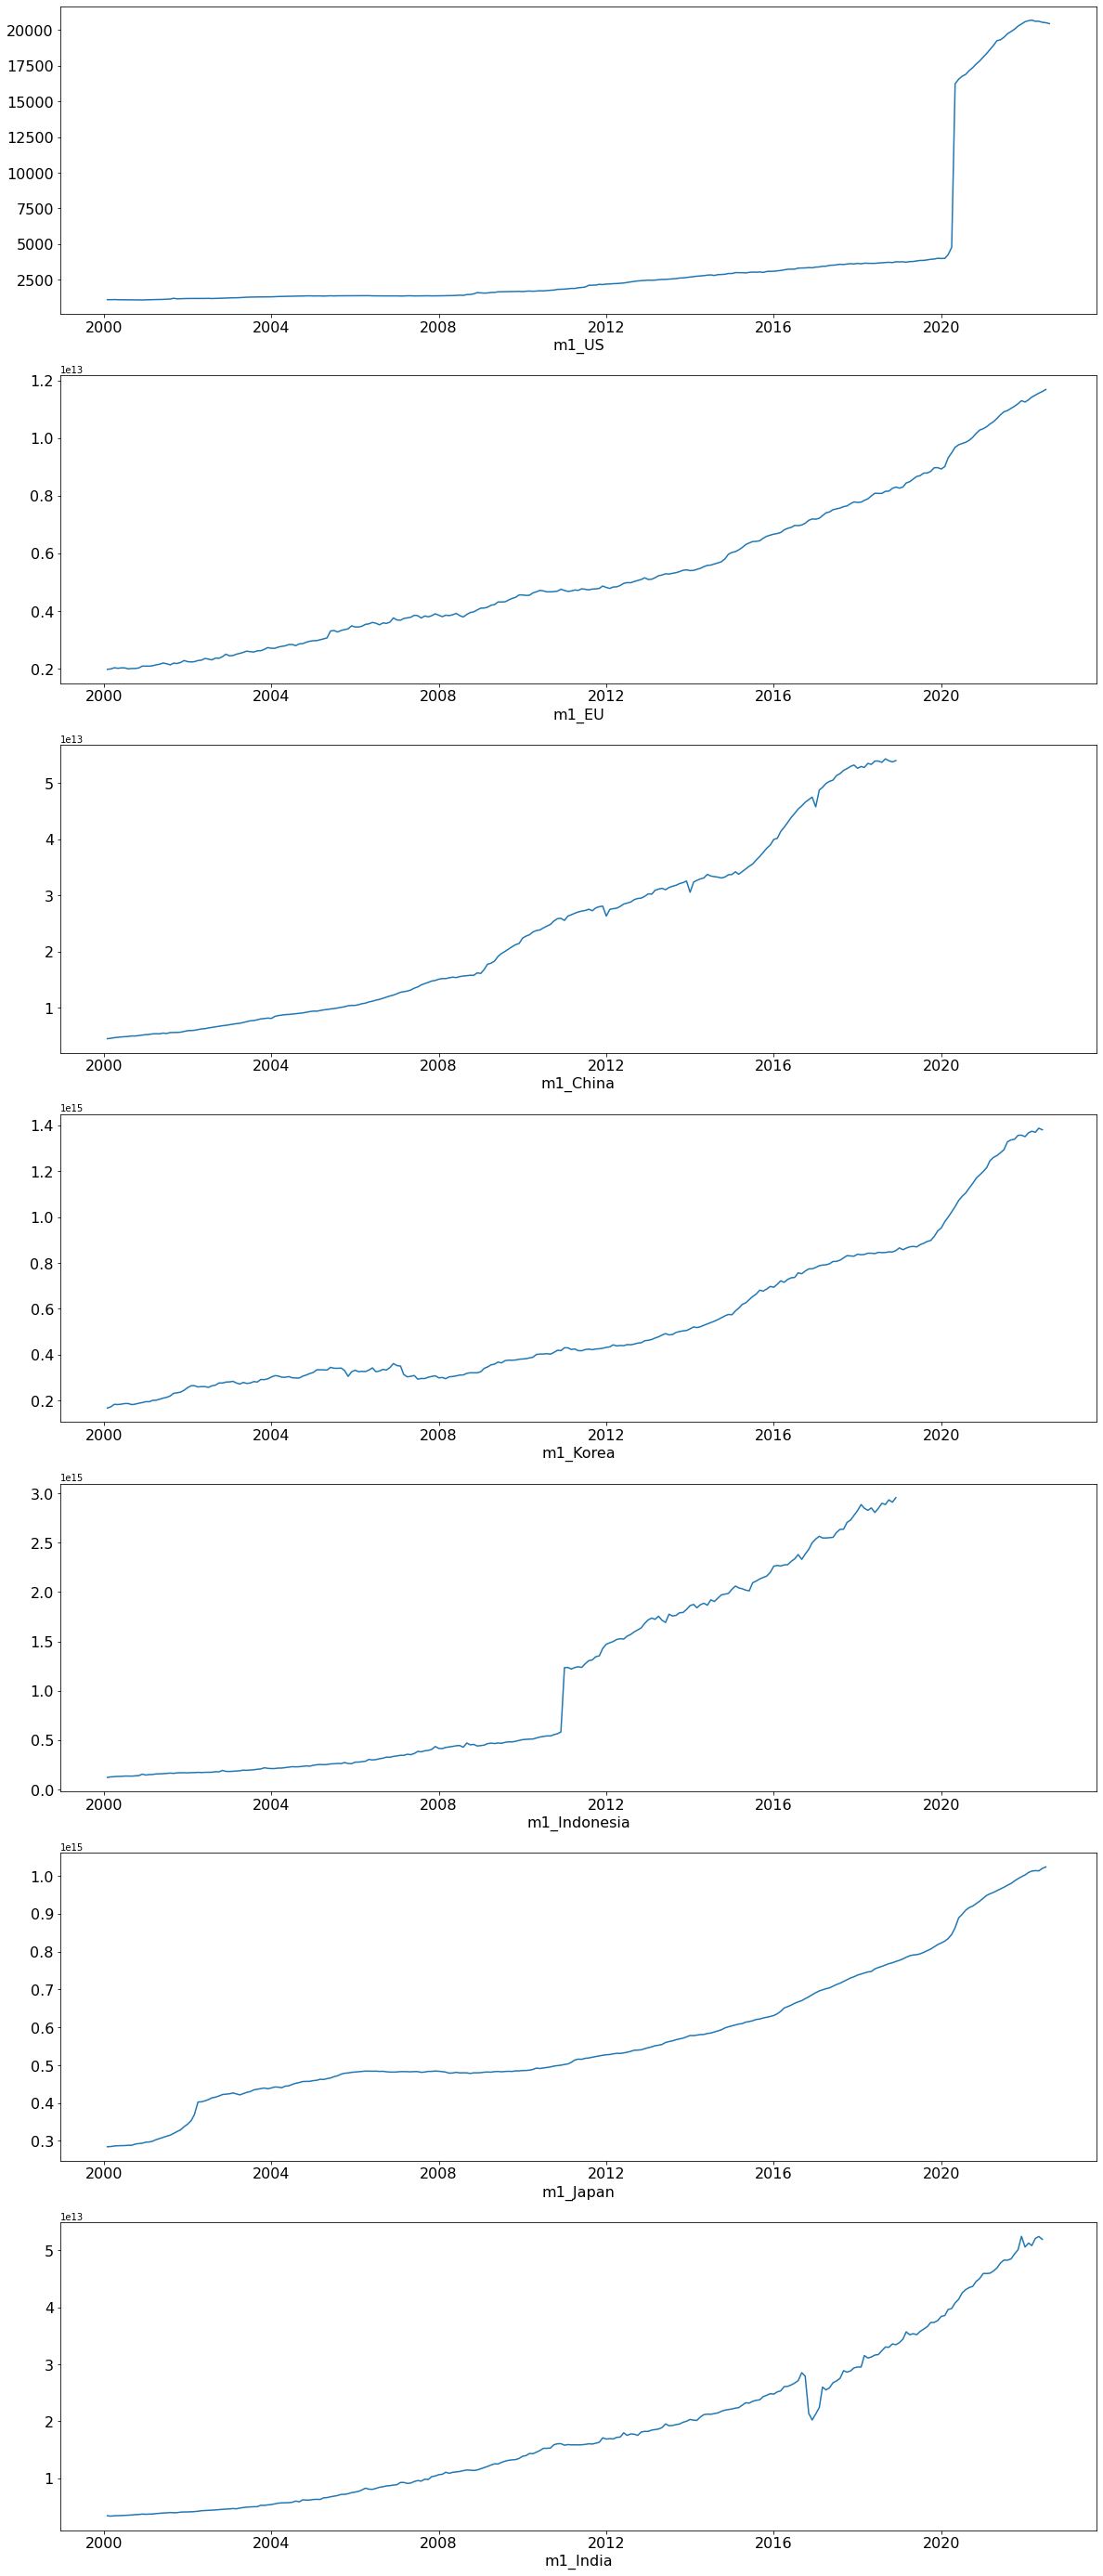

In [ ]:
def plot_m1_ts(time_series_df:pd.DataFrame):
  """
  Function that creating a plotting grid and populates every subplot by a time series plot.
  """

  n_ts = time_series_df.shape[1]

  fig, axs = plt.subplots(n_ts, 1, sharex=True, figsize=(20, 50))

  for asset in range(n_ts):

    axs[asset].plot(time_series_df.iloc[:,asset])
    axs[asset].set_xlabel(time_series_df.columns[asset], fontsize=16)
    axs[asset].tick_params(axis='both', which='both', labelsize=16, labelbottom=True)


plot_m1_ts(m1_ts_df[m1_ts_df.index > '2000-01-01'])

I also decided to start from 2000, as there, most central banks begin, gradually, to conduct an excessive, expansive monetary policy. Before that, M1 was stagnated, making the time interval from the start until 2000 uninsightful.

### Getting asset price data for selected assets

The selection of assets that are meant to be part of the long part of the portfolio was made by the following criteria: potential power to set prices (monopolists are natural examples for this category), high dividends in the past, or an inelastic demand in the company's products (e.g. tobacco). The idea behind this selection is that these companies were and will be able to realize high profits, mostly independent of policy makers, which always are a source of uncertainty.

Candidates which we might want to short-sell are inspired by Ray Dalio's recommendations (https://www.bloomberg.com/news/articles/2022-06-23/bridgewater-doubles-bet-against-european-stocks-to-10-5-billion). I believe that the EU will further lose influence and relevance, thus also economic relevance, leading to me having even lower expectations for the future of the EU than the market has. 

#### Define lists of candidates and get data

In [ ]:
def get_ts_df_yahoo(ts_dict:dict, time_period:str):
  """
  Function that takes in a dictionary containing a yahoo finance ticker that outputs a pandas dataframe of all assets in the dictionary.
  In time period (e.g. "5y"), the analyst can choose how long the time series should be, going backwards from the current date. 
  """
  all_ts = yf.Tickers(list(ts_dict.values())).history(period=time_period)

  return all_ts.Close 

In [ ]:
# Define dictionaries of short and long candidates

short_candidates = {"Intesa(Ita.Bank)":"ISP.MI",
              "BancoBilbao":"BBVA",
              "DAX":"^GDAXI"}

long_candidates = {"PhilippMorris":"PM",
              "Heineken":"HEIA.AS",
              "LVMH":"MC.PA",
              "Starbucks":"SBUX",
              "Gold$":"GC=F",
              "Silber$":"SI=F",
              "Amazon":"AMZN",
              "Meta":'META',
              "Alphabet":'GOOG',
              "Tesla":"TSLA",
              "SP500":'^GSPC'}

candidate_dict = {"short_candidates":short_candidates,
                  "long_candidates":long_candidates}

# Download data by applying the above created function

asset_ts = {investment_type:get_ts_df_yahoo(type_dict, time_period="23y") for investment_type, type_dict in candidate_dict.items()}

# Rename column names with actual labels

asset_ts["short_candidates"] = asset_ts["short_candidates"].rename(columns={label:key for key, label in short_candidates.items()})
asset_ts["long_candidates"] = asset_ts["long_candidates"].rename(columns={label:key for key, label in long_candidates.items()})

# Join long and short positions into one dataframe

asset_ts_df = pd.concat(asset_ts.values(), axis=1, join='inner')

### Merging the money market data with the asset price data

In [ ]:
asset_m1_ts_df = pd.concat([asset_ts_df, m1_ts_df], axis=1, join='inner')
asset_m1_ts_df.tail(3)

,BancoBilbao,Intesa(Ita.Bank),DAX,Amazon,Gold$,Alphabet,Heineken,LVMH,Meta,PhilippMorris,...,Silber$,Tesla,SP500,m1_US,m1_EU,m1_China,m1_Korea,m1_Indonesia,m1_Japan,m1_India
2022-06-01,5.21625,2.0000,14340.469727,121.683998,1843.300049,114.137001,91.132454,597.799988,188.639999,102.978287,...,21.884001,246.789993,4101.229980,20545.0,1.161842e+13,NaN,1.380592e+15,NaN,1.019765e+15,5.193918e+13
2022-07-01,4.42650,1.7676,12813.030273,109.559998,1798.900024,109.081001,88.029060,580.000000,160.029999,98.315491,...,19.597000,227.263336,3825.330078,20516.0,1.168861e+13,NaN,NaN,NaN,1.023683e+15,NaN
2022-08-01,4.35825,1.7492,13479.629883,135.389999,1769.000000,115.480003,95.250427,688.299988,159.929993,97.092957,...,20.322001,297.276672,4118.629883,20452.9,NaN,NaN,NaN,NaN,NaN,NaN


## Answer to Question 1: Are the markets and certain single stocks overvalued? 

Unfortunately, our data source FRED provided us just with monthly data on M1, reducing the number of samples that we end up having for our first analysis. One could follow the hypothesis that the post-covid all-time highs of certain tech stocks might have highly correlated with the expansive monetary policy. Therefore, let us check out the correlations:

In [ ]:
correlation_matrix = asset_m1_ts_df.corr(method="pearson")

In [ ]:
correlation_matrix.loc[["Amazon", "Alphabet", "Meta", "Tesla"], ["m1_US", "m1_EU"]].style.background_gradient(cmap='Greens')

,m1_US,m1_EU
Amazon,0.915946,0.917791
Alphabet,0.923788,0.946512
Meta,0.790266,0.919932
Tesla,0.934744,0.807563


We can observe a very high correlation of all titles with M1, indicating that reducing M1 might be associated with stock prices of these companies falling. Even though these companies, except for Tesla, have a monopolistic price setting power and feature an inelastic demand in their products, due to their addictive tendencies, investments may have to be reconsidered. 

## Question 2: Are non-tech assets also highly correlated with M1?

In [ ]:
correlation_matrix.loc[["Heineken", "LVMH", "PhilippMorris", "Silber$", "Gold$", "BancoBilbao", "Intesa(Ita.Bank)", "DAX", "SP500"], ["m1_US", "m1_EU"]].style.background_gradient(cmap='Greens')

,m1_US,m1_EU
Heineken,0.709332,0.927112
LVMH,0.941422,0.919357
PhilippMorris,0.660775,0.862552
Silber$,0.352648,0.495735
Gold$,0.626281,0.824868
BancoBilbao,-0.259190,-0.183330
Intesa(Ita.Bank),0.505244,0.505827
DAX,0.741639,0.924414
SP500,0.885634,0.932857


Even non-tech assets are highly correlated with M1. One exception is the Banco Bilbao!

## Question 3: What about the correlation of the assets among each other? 

For this, we can use all samples that we have, as we have daily data.

In [ ]:
correlation_matrix_all_assets = asset_ts_df.corr(method="pearson")
correlation_matrix_all_assets.style.background_gradient(cmap='Greens')

,BancoBilbao,Intesa(Ita.Bank),DAX,Amazon,Gold$,Alphabet,Heineken,LVMH,Meta,PhilippMorris,Starbucks,Silber$,Tesla,SP500
BancoBilbao,1.000000,0.470612,-0.057553,-0.304018,-0.147107,-0.427504,-0.235388,-0.245404,-0.362795,-0.336605,-0.235671,0.023697,-0.220314,-0.179734
Intesa(Ita.Bank),0.470612,1.000000,0.617044,0.490419,0.150307,0.502490,0.510849,0.514955,0.756805,0.604599,0.505367,-0.045342,0.602991,0.596445
DAX,-0.057553,0.617044,1.000000,0.850367,0.745157,0.884682,0.954885,0.853329,0.913378,0.912778,0.922289,0.453061,0.681824,0.936592
Amazon,-0.304018,0.490419,0.850367,1.000000,0.677013,0.957932,0.868784,0.962661,0.935756,0.751551,0.942241,0.351896,0.822410,0.958495
Gold$,-0.147107,0.150307,0.745157,0.677013,1.000000,0.664957,0.703302,0.696770,0.548766,0.585496,0.729105,0.875665,0.655812,0.690724
Alphabet,-0.427504,0.502490,0.884682,0.957932,0.664957,1.000000,0.859147,0.985509,0.887770,0.819321,0.937039,0.222878,0.912312,0.979736
Heineken,-0.235388,0.510849,0.954885,0.868784,0.703302,0.859147,1.000000,0.858822,0.858243,0.908527,0.946333,0.364525,0.583134,0.926762
LVMH,-0.245404,0.514955,0.853329,0.962661,0.696770,0.985509,0.858822,1.000000,0.856088,0.788323,0.935029,0.394391,0.914094,0.969544
Meta,-0.362795,0.756805,0.913378,0.935756,0.548766,0.887770,0.858243,0.856088,1.000000,0.721862,0.933407,0.028454,0.710815,0.918980
PhilippMorris,-0.336605,0.604599,0.912778,0.751551,0.585496,0.819321,0.908527,0.788323,0.721862,1.000000,0.862517,0.017909,0.686299,0.875992


The prices of Banco Bilbao and Silver seem to be relatively uncorrelated with rest, making them attractive to be part of a risk-minimizing portfolio.

## Question 4: What about other tobacco and alcohol manufacturers? 

# OLD

In [ ]:
candidates = {'EURvCHF':"EURCHF=X",
              "Intesa(Ita.Bank)":"ISP.MI",
              "BancoBilbao":"BBVA",
              "PhilippMorris":"PM",
              "Heineken":"HEIA.AS",
              "LVMH":"MC.PA",
              "Starbucks":"SBUX",
              "Gold$":"GC=F",
              "Silber$":"SI=F",
              "SP500":'^GSPC',
              "DAX":"^GDAXI",
              "MSCI_COMMUNICATION":"FCOM"}
all_ts = yf.Tickers(list(candidates.values())).history(period="5y")
close_prices = all_ts.Close

Normalizing function if plots desired

In [ ]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [ ]:
candidates = {'EURvCHF':"EURCHF=X",
              "Intesa(Ita.Bank)":"ISP.MI",
              "BancoBilbao":"BBVA",
              "PhilippMorris":"PM",
              "Heineken":"HEIA.AS",
              "LVMH":"MC.PA",
              "Starbucks":"SBUX",
              "Gold$":"GC=F",
              "Silber$":"SI=F",
              "SP500":'^GSPC',
              "DAX":"^GDAXI",
              "MSCI_COMMUNICATION":"FCOM"}
all_ts = yf.Tickers(list(candidates.values())).history(period="5y")
close_prices = all_ts.Close

[*********************100%***********************]  12 of 12 completed


In [ ]:
def plot_ts(assets:list):
  """
  Function to plot the specified list of assets. Each of them in a single plot to account for the difference in absolute prices.
  """

  n_plots = len(assets)

  fig, axs = plt.subplots(n_plots, 1, sharex=True, figsize=(15, 7))

  for asset in range(len(assets)):

    axs[asset].plot(close_prices[assets[asset]])
    axs[asset].set_xlabel(assets[asset])


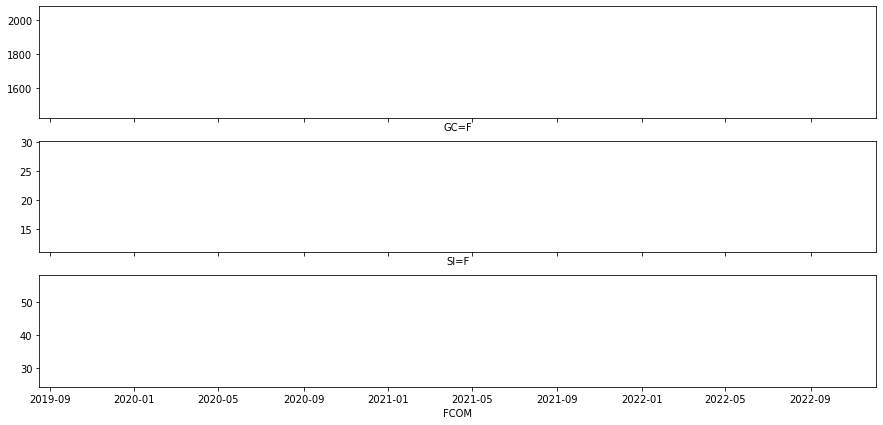

In [ ]:
plot_ts(["GC=F", "SI=F", "FCOM"])

Compute correlation matrix

In [ ]:
correlation_matrix = close_prices.corr(method="pearson")
correlation_matrix.style.background_gradient(cmap='Greens')


,BBVA,EURCHF=X,FCOM,GC=F,HEIA.AS,ISP.MI,MC.PA,PM,SBUX,SI=F,^GDAXI,^GSPC
BBVA,1.000000,nan,0.735205,0.014910,nan,nan,nan,0.769942,0.725627,0.359311,nan,0.807840
EURCHF=X,nan,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
FCOM,0.735205,nan,1.000000,0.420338,nan,nan,nan,0.538971,0.930728,0.746341,nan,0.831396
GC=F,0.014910,nan,0.420338,1.000000,nan,nan,nan,0.308143,0.216550,0.761829,nan,0.475934
HEIA.AS,nan,nan,nan,nan,1.000000,0.756454,0.666247,nan,nan,nan,0.724930,nan
ISP.MI,nan,nan,nan,nan,0.756454,1.000000,0.809136,nan,nan,nan,0.913495,nan
MC.PA,nan,nan,nan,nan,0.666247,0.809136,1.000000,nan,nan,nan,0.797307,nan
PM,0.769942,nan,0.538971,0.308143,nan,nan,nan,1.000000,0.472340,0.366017,nan,0.854033
SBUX,0.725627,nan,0.930728,0.216550,nan,nan,nan,0.472340,1.000000,0.632857,nan,0.758906
SI=F,0.359311,nan,0.746341,0.761829,nan,nan,nan,0.366017,0.632857,1.000000,nan,0.622356


Berechnung durchschnittlicher, absoluter Korrelationen

In [ ]:
correlation_matrix.abs().mean(axis=0)

BBVA        0.633769
EURCHF=X    0.375154
FCOM        0.602447
GC=F        0.355100
HEIA.AS     0.560745
ISP.MI      0.605152
MC.PA       0.649094
PM          0.521914
SBUX        0.544551
SI=F        0.351718
^GDAXI      0.663048
^GSPC       0.627207
dtype: float64

In [ ]:
tabak_alkohol = ["PM", "BTI", "MO", "JAPAY", "MC.PA", "STZ", "BF-B", "DEO", "RI.PA", "CPR.MI"]

In [ ]:
tabak_alkoholwerte = yf.Tickers(tabak_alkohol).history(period="3y").loc['2020-01-15':, :]
tabak_alk_price = tabak_alkoholwerte.Close
tabak_alk_price